## Debugging the `LabelModel` with deps + higher-order cliques

In [1]:
%matplotlib inline
import sys
sys.path.append("../") # go to parent dir

import numpy as np
import torch
import matplotlib.pyplot as plt
import mpmath

from synthetic.generate import SingleTaskTreeDepsGenerator
from metal.label_model import LabelModel
from metal.label_model.utils import (
    compute_mu,
    compute_covariance,
    compute_inv_covariance,
    print_matrix,
    visualize_matrix
)

### Generating a dataset

In [2]:
# Generate synthetic dataset
np.random.seed(1)
N = 10000
M = 10
K = 2
EDGE_PROB=1.0
data = SingleTaskTreeDepsGenerator(N, M, k=K, edge_prob=EDGE_PROB)



(0, 1)   [0.92256582 0.51148433]
(0, 2)   [0.48762871 0.94521501]
(1, 1)   [0.80055031 0.74437346]
(1, 2)   [0.82248175 0.18352073]
(2, 1)   [0.56633729 0.87851823]
(2, 2)   [0.84623222 0.84664302]
(3, 1)   [0.34574498 0.15331888]
(3, 2)   [0.70347524 0.63375897]
(4, 1)   [0.70448869 0.47060909]
(4, 2)   [0.27779581 0.36066668]
(5, 1)   [0.22790812 0.80498303]
(5, 2)   [0.47128496 0.13075418]
(6, 1)   [0.66162699 0.69457216]
(6, 2)   [0.36864577 0.50152106]
(7, 1)   [0.29991209 0.16602775]
(7, 2)   [0.52231467 0.18655503]
(8, 1)   [0.91303315 0.20754142]
(8, 2)   [0.57231944 0.1752607 ]
(9, 1)   [0.9251752  0.91940354]
(9, 2)   [0.3690371  0.62595021]
((0, 1), 1, 1)   [0.60932082 0.65254449]
((0, 1), 1, 2)   [0.96088209 0.33488108]
((0, 1), 2, 1)   [0.30791388 0.58010364]
((0, 1), 2, 2)   [0.95494432 0.54375363]
((1, 2), 1, 1)   [0.58654046 0.78893659]
((1, 2), 1, 2)   [0.14081116 0.22596951]
((1, 2), 2, 1)   [0.81316323 0.12682122]
((1, 2), 2, 2)   [0.89481293 0.58670937]
((0, 3), 1, 

P(L_ 1 = 2 , L_ 5 = 1  | Y =  1 ) =  0.19824689381937038
P(L_ 1 = 2 , L_ 5 = 2  | Y =  1 ) =  0.38283108490494355
Labelers =  (1, 6)
P(L_ 1 = 0 , L_ 6 = 0  | Y =  1 ) =  0.009526136592582881
P(L_ 1 = 0 , L_ 6 = 1  | Y =  1 ) =  0.028712493193954768
P(L_ 1 = 0 , L_ 6 = 2  | Y =  1 ) =  0.016734292620842285
P(L_ 1 = 1 , L_ 6 = 0  | Y =  1 ) =  0.04467484582787258
P(L_ 1 = 1 , L_ 6 = 1  | Y =  1 ) =  0.14500972314039762
P(L_ 1 = 1 , L_ 6 = 2  | Y =  1 ) =  0.08132086311246653
P(L_ 1 = 2 , L_ 6 = 0  | Y =  1 ) =  0.11467602329113516
P(L_ 1 = 2 , L_ 6 = 1  | Y =  1 ) =  0.35509415026531654
P(L_ 1 = 2 , L_ 6 = 2  | Y =  1 ) =  0.20425147195543134
Labelers =  (1, 7)
P(L_ 1 = 0 , L_ 7 = 0  | Y =  1 ) =  0.009610732229828
P(L_ 1 = 0 , L_ 7 = 1  | Y =  1 ) =  0.024592257970255226
P(L_ 1 = 0 , L_ 7 = 2  | Y =  1 ) =  0.020769932207296712
P(L_ 1 = 1 , L_ 7 = 0  | Y =  1 ) =  0.0473662929046579
P(L_ 1 = 1 , L_ 7 = 1  | Y =  1 ) =  0.12130174561120088
P(L_ 1 = 1 , L_ 7 = 2  | Y =  1 ) =  0.102337393

Labelers =  (4, 6)
P(L_ 4 = 0 , L_ 6 = 0  | Y =  1 ) =  0.018162712499619267
P(L_ 4 = 0 , L_ 6 = 1  | Y =  1 ) =  0.05688754356182601
P(L_ 4 = 0 , L_ 6 = 2  | Y =  1 ) =  0.0325165015245963
P(L_ 4 = 1 , L_ 6 = 0  | Y =  1 ) =  0.06570811024630711
P(L_ 4 = 1 , L_ 6 = 1  | Y =  1 ) =  0.20571519967598428
P(L_ 4 = 1 , L_ 6 = 2  | Y =  1 ) =  0.11761317191018707
P(L_ 4 = 2 , L_ 6 = 0  | Y =  1 ) =  0.08500618296566426
P(L_ 4 = 2 , L_ 6 = 1  | Y =  1 ) =  0.2662136233618588
P(L_ 4 = 2 , L_ 6 = 2  | Y =  1 ) =  0.1521769542539568
Labelers =  (4, 7)
P(L_ 4 = 0 , L_ 7 = 0  | Y =  1 ) =  0.01925701348185254
P(L_ 4 = 0 , L_ 7 = 1  | Y =  1 ) =  0.046235861299082054
P(L_ 4 = 0 , L_ 7 = 2  | Y =  1 ) =  0.04207388280510701
P(L_ 4 = 1 , L_ 7 = 0  | Y =  1 ) =  0.06896290407750161
P(L_ 4 = 1 , L_ 7 = 1  | Y =  1 ) =  0.16879415841027404
P(L_ 4 = 1 , L_ 7 = 2  | Y =  1 ) =  0.15127941934470288
P(L_ 4 = 2 , L_ 7 = 0  | Y =  1 ) =  0.08657453129463706
P(L_ 4 = 2 , L_ 7 = 1  | Y =  1 ) =  0.232479891022

P(L_ 0 = 0 , L_ 5 = 1  | Y =  2 ) =  0.026165718037244774
P(L_ 0 = 0 , L_ 5 = 2  | Y =  2 ) =  0.014958865028603427
P(L_ 0 = 1 , L_ 5 = 0  | Y =  2 ) =  0.04043846299552396
P(L_ 0 = 1 , L_ 5 = 1  | Y =  2 ) =  0.21877971186765233
P(L_ 0 = 1 , L_ 5 = 2  | Y =  2 ) =  0.1283448284882028
P(L_ 0 = 2 , L_ 5 = 0  | Y =  2 ) =  0.060825499634332404
P(L_ 0 = 2 , L_ 5 = 1  | Y =  2 ) =  0.3232481241530389
P(L_ 0 = 2 , L_ 5 = 2  | Y =  2 ) =  0.18216618670981646
Labelers =  (0, 6)
P(L_ 0 = 0 , L_ 6 = 0  | Y =  2 ) =  0.0055434123957499425
P(L_ 0 = 0 , L_ 6 = 1  | Y =  2 ) =  0.021762021691540248
P(L_ 0 = 0 , L_ 6 = 2  | Y =  2 ) =  0.018891752064142946
P(L_ 0 = 1 , L_ 6 = 0  | Y =  2 ) =  0.04635087404410608
P(L_ 0 = 1 , L_ 6 = 1  | Y =  2 ) =  0.1828166533822908
P(L_ 0 = 1 , L_ 6 = 2  | Y =  2 ) =  0.15839547592498224
P(L_ 0 = 2 , L_ 6 = 0  | Y =  2 ) =  0.06782413241459707
P(L_ 0 = 2 , L_ 6 = 1  | Y =  2 ) =  0.2668654888359076
P(L_ 0 = 2 , L_ 6 = 2  | Y =  2 ) =  0.23155018924668305
Labelers 

P(L_ 2 = 0 , L_ 9 = 0  | Y =  2 ) =  0.007976775596397381
P(L_ 2 = 0 , L_ 9 = 1  | Y =  2 ) =  0.020004111207796934
P(L_ 2 = 0 , L_ 9 = 2  | Y =  2 ) =  0.014916746050644955
P(L_ 2 = 1 , L_ 9 = 0  | Y =  2 ) =  0.06448874685950404
P(L_ 2 = 1 , L_ 9 = 1  | Y =  2 ) =  0.25533495791957816
P(L_ 2 = 1 , L_ 9 = 2  | Y =  2 ) =  0.2108759825599215
P(L_ 2 = 2 , L_ 9 = 0  | Y =  2 ) =  0.044736610553688265
P(L_ 2 = 2 , L_ 9 = 1  | Y =  2 ) =  0.1607807744139801
P(L_ 2 = 2 , L_ 9 = 2  | Y =  2 ) =  0.22088529483848854
Labelers =  (3, 4)
P(L_ 3 = 0 , L_ 4 = 0  | Y =  2 ) =  0.012331671764968088
P(L_ 3 = 0 , L_ 4 = 1  | Y =  2 ) =  0.05687902588900653
P(L_ 3 = 0 , L_ 4 = 2  | Y =  2 ) =  0.049812802101756974
P(L_ 3 = 1 , L_ 4 = 0  | Y =  2 ) =  0.03174143983479201
P(L_ 3 = 1 , L_ 4 = 1  | Y =  2 ) =  0.15522905824672217
P(L_ 3 = 1 , L_ 4 = 2  | Y =  2 ) =  0.12550460707184002
P(L_ 3 = 2 , L_ 4 = 0  | Y =  2 ) =  0.05743564896258119
P(L_ 3 = 2 , L_ 4 = 1  | Y =  2 ) =  0.2697679417320759
P(L_ 3 = 

P(L_ 7 = 1 , L_ 9 = 1  | Y =  2 ) =  0.1964435418955999
P(L_ 7 = 1 , L_ 9 = 2  | Y =  2 ) =  0.2011994646217449
P(L_ 7 = 2 , L_ 9 = 0  | Y =  2 ) =  0.04078497190592266
P(L_ 7 = 2 , L_ 9 = 1  | Y =  2 ) =  0.15176468631663867
P(L_ 7 = 2 , L_ 9 = 2  | Y =  2 ) =  0.15543844008286703
Labelers =  (8, 9)
P(L_ 8 = 0 , L_ 9 = 0  | Y =  2 ) =  0.026772557548585315
P(L_ 8 = 0 , L_ 9 = 1  | Y =  2 ) =  0.09962319961934055
P(L_ 8 = 0 , L_ 9 = 2  | Y =  2 ) =  0.10203423860853238
P(L_ 8 = 1 , L_ 9 = 0  | Y =  2 ) =  0.04204866106147624
P(L_ 8 = 1 , L_ 9 = 1  | Y =  2 ) =  0.156467472756626
P(L_ 8 = 1 , L_ 9 = 2  | Y =  2 ) =  0.1602528271560815
P(L_ 8 = 2 , L_ 9 = 0  | Y =  2 ) =  0.04838091439952814
P(L_ 8 = 2 , L_ 9 = 1  | Y =  2 ) =  0.1800291711653887
P(L_ 8 = 2 , L_ 9 = 2  | Y =  2 ) =  0.1843909576844411
[[0.44892041 0.         0.1979985  0.21982931 0.23184051 0.19017902
  0.18622118 0.21511018 0.19335238 0.20566561 0.17832659 0.21534878
  0.22735624 0.15450669 0.20172626 0.16408343 0.21904

In [19]:
data.mu_true

array([[0.5004242 , 0.387563  ],
       [0.45909729, 0.56623981],
       [0.27100543, 0.63124965],
       [0.67402165, 0.26832099],
       [0.49940803, 0.53069969],
       [0.42987081, 0.42640268],
       [0.43708518, 0.31247511],
       [0.4633325 , 0.5685014 ],
       [0.38903648, 0.48187603],
       [0.50339676, 0.41661521],
       [0.29401042, 0.56819355],
       [0.56813275, 0.32546988],
       [0.52881637, 0.47144416],
       [0.30230663, 0.40883742],
       [0.44750991, 0.45043493],
       [0.37769564, 0.3479881 ],
       [0.57086411, 0.35876896],
       [0.30084298, 0.41280104],
       [0.52416203, 0.43611984],
       [0.30724142, 0.44667802]])

In [6]:
data.O_true.shape

(20, 20)

In [4]:
data.E

[(0, 1), (1, 2), (0, 3), (0, 4), (4, 5), (2, 6), (5, 7), (3, 8), (2, 9)]

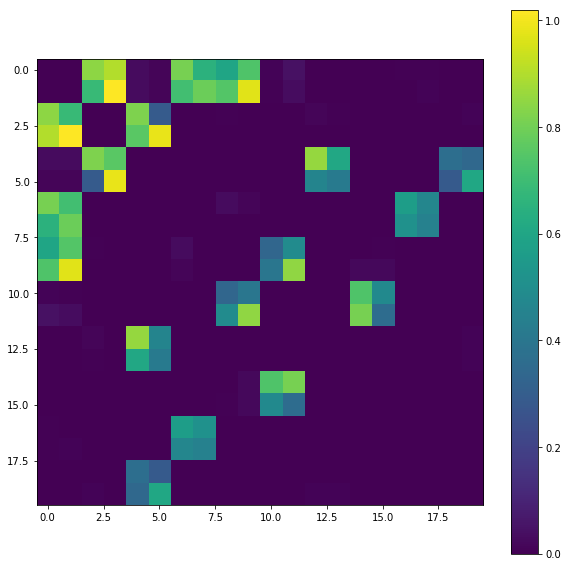

In [3]:
# mask the diagonals so we don't get influenced by them unfairly
sg_no_diag = np.copy(data.sig_inv)
for i in range(M):
    sg_no_diag[i*2:i*2+2,i*2:i*2+2] = np.zeros([2,2])

visualize_matrix(np.abs(sg_no_diag))

In [27]:
lm = LabelModel(k=data.k, class_balance=data.p)

# Get the exact O_inv
O_inv = np.linalg.inv(data.O_true)

# Generate c_data: clique data structure
# Normally this is assembled while computing O, but if we pass in O
# ourselves, we need to construct this data structure too...
lm._set_constants(data.L)
lm._set_dependencies(data.E)
c_data = {}
for i in range(data.m):
    c_data[i] = {
        'start_index': i*data.k,
        'end_index': (i+1)*data.k,
        'max_cliques': set([j for j in lm.c_tree.nodes() 
            if i in lm.c_tree.node[j]['members']])
    }

lm.train(
    data.L,
    deps=data.E,
    all_unary_cliques=True,
    higher_order_cliques=False,
    n_epochs=5000,
    print_every=1000,
    lr=0.01,
    l2=0,
    O_inv_prec=1024,
    O=data.O_true,
    O_inv=O_inv,
    c_data=c_data
)

mu_est = lm.mu.detach().numpy() # Note: we can swap column order
mu_est_swapped = lm.mu.detach().numpy()[:,::-1] # Note: we can swap column order
print(f"Average absolute error: {np.mean(np.abs(mu_est - data.mu_true))}")
print(f"Average absolute error -- cols swapped: {np.mean(np.abs(mu_est_swapped - data.mu_true))}")

Estimating Z...
[Epoch 0] Loss: 1128.407593
[Epoch 1000] Loss: 0.012238
[Epoch 2000] Loss: 0.012238
[Epoch 3000] Loss: 0.012238
[Epoch 4000] Loss: 0.012238
[Epoch 4999] Loss: 0.012238
Estimating \mu...
[Epoch 0] Loss: 14.685292
[Epoch 1000] Loss: 0.000002
[Epoch 2000] Loss: 0.000000
[Epoch 3000] Loss: 0.000000
[Epoch 4000] Loss: 0.000000
[Epoch 4999] Loss: 0.000000
Average absolute error: 0.000638746893010983
Average absolute error -- cols swapped: 0.13478459300640178


### Training the `LabelModel`

Note that:
* The `train` method assembles other data structures, such as the dependencies junction tree, etc.
* The `higher_order_cliques` kwarg controls whether or not to include them

In [ ]:
lm = LabelModel(k=data.k, class_balance=data.p)

In [ ]:
lm.config['higher_order_cliques'] = True

In [ ]:
'''# Generate the "correct" mu
lm._set_constants(data.L)
lm._set_dependencies(data.E)
mu = compute_mu(lm._get_augmented_label_matrix(data.L.todense()), data.Y, K, data.p)

# Compute O, O_inv, P based on L
lm._generate_O(data.L.todense())
O = lm.O.numpy()
print(O)
d, d = O.shape
O_inv = np.linalg.inv(O)
P = np.diag(data.p)

JJT = np.linalg.inv(np.linalg.inv(P) - mu.T @ O_inv @ mu)
ZZT = O_inv @ mu @ JJT @ mu.T @ O_inv.T'''

In [ ]:
# Check that JJT is indeed PSD ==> ZZT is rank k
#np.linalg.eig(JJT)[0]

In [ ]:
#np.linalg.eig((ZZT + ZZT.T)/2)[0]

In [ ]:
lm.train(
    data.L,
    deps=data.E,
    all_unary_cliques=True,
    higher_order_cliques=True,
    n_epochs=50000,
    print_every=5000,
    lr=0.0001,
    l2=0,
    O_inv_prec=1024,
    #O_inv=ZZT
)

lm._set_constants(data.L)
lm._set_dependencies(data.E)
mu = compute_mu(lm._get_augmented_label_matrix(data.L.todense()), data.Y, K, data.p)


# Test against the true parameter values
mu_est = lm.mu.detach().numpy()
print(mu)
print(mu_est)
print(f"Average absolute error: {np.mean(np.abs(mu_est - mu))}")

### Sanity check that the true $Z$ gets lower loss

In [ ]:
sorted(np.linalg.eig(O)[0])[::-1]

In [ ]:
O = lm.O.numpy()
d, d = O.shape
O_inv = lm.O_inv.numpy()
mask = lm.mask.numpy()
P = lm.P.numpy()

JJT = np.linalg.inv(np.linalg.inv(P) - mu.T @ O_inv @ mu)
ZZT = O_inv @ mu @ JJT @ mu.T @ O_inv.T

np.linalg.norm((O_inv + ZZT) * mask)**2

#### Seed=2

In [ ]:
visualize_matrix(mask)

In [ ]:
#visualize_matrix(np.abs((O_inv + ZZT) * mask))

In [ ]:
lm.c_data

In [ ]:
Z_est = lm.Z.detach().numpy()
visualize_matrix(np.abs((O_inv + Z_est @ Z_est.T) * mask))

#### Seed=1

In [ ]:
visualize_matrix(mask)

In [ ]:
visualize_matrix(np.abs((O_inv + ZZT) * mask))

In [ ]:
Z_est = lm.Z.detach().numpy()
visualize_matrix(np.abs((O_inv + Z_est @ Z_est.T) * mask))

#### Seed=0

In [ ]:
visualize_matrix(mask)

In [ ]:
visualize_matrix(np.abs((O_inv + ZZT) * mask))

In [ ]:
Z_est = lm.Z.detach().numpy()
visualize_matrix(np.abs((O_inv + Z_est @ Z_est.T) * mask))

### Visualizing matrices

In [ ]:
visualize_matrix(np.abs(mu_est - mu))

In [ ]:
visualize_matrix(np.abs(mu_est - mu))

In [ ]:
lm.c_data

In [ ]:
data.E

### Trying to solve with `scipy.optimize.minimize`

In [ ]:
from scipy.optimize import minimize

O_inv = lm.O_inv.numpy()
mask = lm.mask.numpy()

z0 = np.random.randn(lm.d * lm.k)
l import LabelModl import LabelModel
from metal.label_model.utils import (
    compute_mu,
    compute_covariance,
    compute_inv_covariance,
    print_matrix,el
from metal.label_model.utils import (
    compute_mu,
    compute_covariance,
    compute_inv_covariance,
    print_matrix,
def objective_fn(z):
    Z = z.reshape(-1, data.k)
    return np.linalg.norm( (O_inv + Z @ Z.T) * mask )**2

def gradient_fn(z):
    Z = z.reshape(-1, data.k)
    X = (O_inv + Z @ Z.T) * mask
    return np.ravel(X @ Z)

res = minimize(objective_fn, z0, jac=gradient_fn, method='BFGS')
Z = res['x'].reshape(-1, data.k)
res['fun']

In [ ]:
O = lm.O.numpy()
P = lm.P.numpy()
I_k = np.eye(data.k)
Q = O @ Z @ np.linalg.inv(I_k + Z.T @ O @ Z) @ Z.T @ O

mu0 = np.random.randn(lm.d * lm.k)

def objective_fn_2(mu):
    M = mu.reshape(-1, data.k)
    return np.linalg.norm(Q - M @ P @ M.T)**2 + np.linalg.norm(np.sum(M @ P, 1) - np.diag(O))**2

res_2 = minimize(objective_fn_2, mu0, method='BFGS')
M = res_2['x'].reshape(-1, data.k)
res_2['fun']

In [ ]:
# Test against the true parameter values
print(f"Average absolute error: {np.mean(np.abs(M - mu))}")

## Visualizing the inverse covariance matrix

In [ ]:
J = compute_inv_covariance(
    lm._get_augmented_label_matrix(data.L.todense()),
    data.Y,
    data.k,
    data.p
)
visualize_matrix(np.abs(J))

In [ ]:
visualize_matrix(lm.mask.numpy(), fig_size=[5,5])

In [ ]:
O_inv = lm.O_inv.numpy()
Z = lm.Z.detach().numpy()
mask = lm.mask.numpy()
visualize_matrix(np.abs((O_inv + Z@Z.T) * mask))

### Looking at the internal 'bookkeeping' of cliques...

In [ ]:
lm.c_data

In [ ]:
# Dependency edge weights
[((i,j), data.theta[(i,j)]) for i,j in data.E]